Trajectories saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.1_base_high_step_0.10.npy


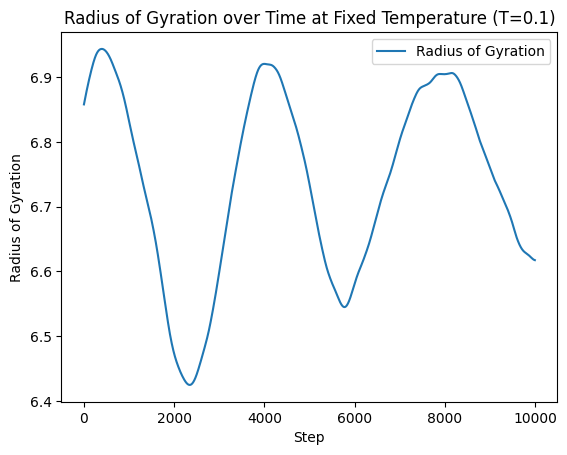

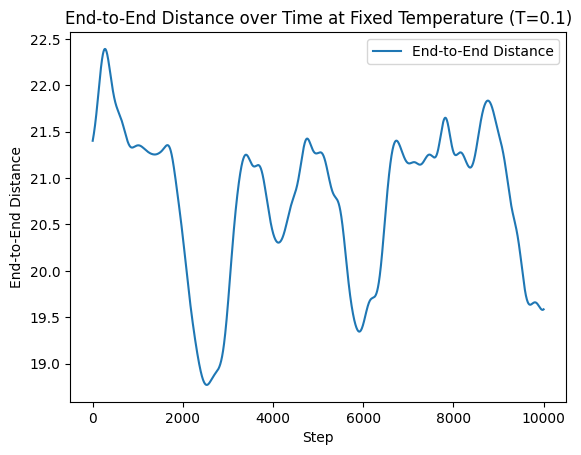

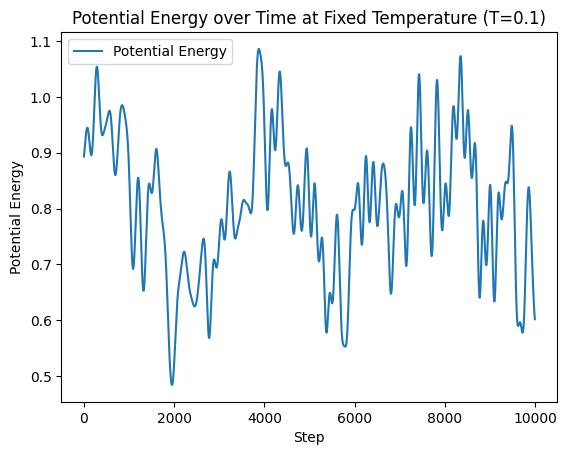

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view
import os

# Directory to store trajectories
output_dir = r"C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 150000  # Number of steps
box_size = 100.0  # Size of the cubic box
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
k = 1.0  # Spring constant
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential (fixed)
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant
target_temperature = 0.1  # Fixed temperature

# Directory to store trajectories
output_dir = r"C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, k):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Initialize positions and velocities
positions = initialize_chain(n_particles, box_size, r0)
velocities = initialize_velocities(n_particles, target_temperature, mass)
forces = compute_harmonic_forces(positions, k, r0, box_size) + \
         compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
         compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

# Arrays to store properties during sampling
Rg_values = []
Ree_values = []
potential_energies = []

# Initialize an empty list to store trajectories after equilibration
trajectories = []

# Run simulation loop
for step in range(total_steps):
    positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, k)
    if step % rescale_interval == 0:
        velocities = rescale_velocities(velocities, target_temperature, mass)

    # Store trajectories only after equilibration (step >= 140,000)
    if step >= 140000:
        trajectories.append(positions.copy())  # Store a copy of the positions at each step

        # Compute properties for this step
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        # Lennard-Jones Potentials
        def lj_repulsive_potential(r, epsilon, sigma):
            if r < 2**(1/6) * sigma:
                return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6 + 0.25)
            return 0.0

        def lj_attractive_potential(r, epsilon, sigma):
            return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

        E_LJ = 0.0
        for i in range(n_particles - 1):
            for j in range(i + 1, n_particles):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff:
                    if abs(i - j) == 2:
                        # Repulsive Lennard-Jones Potential
                        E_LJ += lj_repulsive_potential(distance, epsilon_repulsive, sigma)
                    elif abs(i - j) > 2:
                        # Attractive Lennard-Jones Potential
                        E_LJ += lj_attractive_potential(distance, epsilon_attractive, sigma)

        potential_energy = E_harmonic + E_LJ

        # Store values
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)

# Convert lists to NumPy arrays for easier calculations
Rg_values = np.array(Rg_values)
Ree_values = np.array(Ree_values)
potential_energies = np.array(potential_energies)
trajectories = np.array(trajectories)  # Convert the trajectory list to a NumPy array

# Save the trajectory data
trajectory_file_path = os.path.join(output_dir, f"trajectories_T_0.1_base_high_step_{target_temperature:.2f}.npy")
np.save(trajectory_file_path, trajectories)
print(f"Trajectories saved to: {trajectory_file_path}")

# Plotting the results
plt.figure()
plt.plot(Rg_values, label='Radius of Gyration')
plt.xlabel('Step')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration over Time at Fixed Temperature (T=0.1)')
plt.legend()
plt.show()

plt.figure()
plt.plot(Ree_values, label='End-to-End Distance')
plt.xlabel('Step')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance over Time at Fixed Temperature (T=0.1)')
plt.legend()
plt.show()

plt.figure()
plt.plot(potential_energies, label='Potential Energy')
plt.xlabel('Step')
plt.ylabel('Potential Energy')
plt.title('Potential Energy over Time at Fixed Temperature (T=0.1)')
plt.legend()
plt.show()




Trajectories saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.1_opt_high_step_0.10.npy


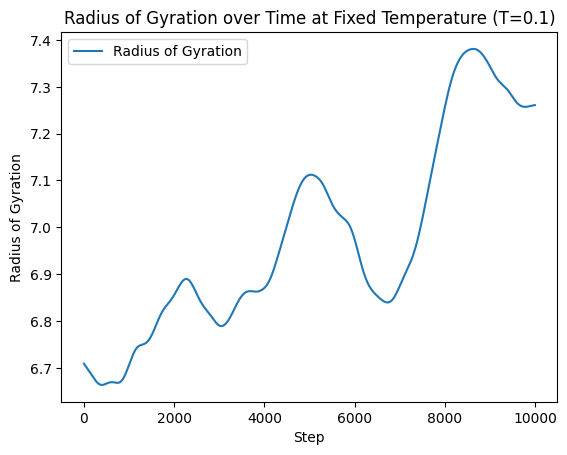

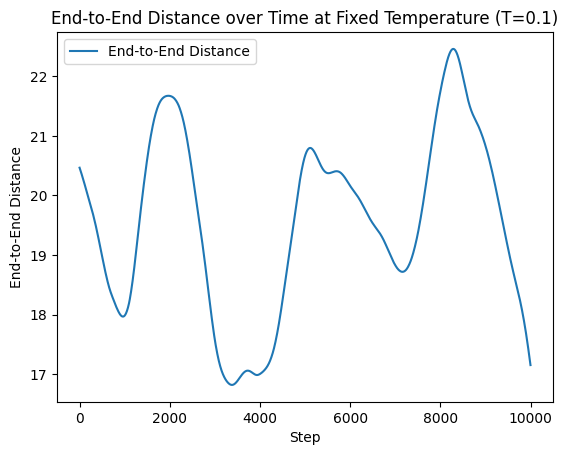

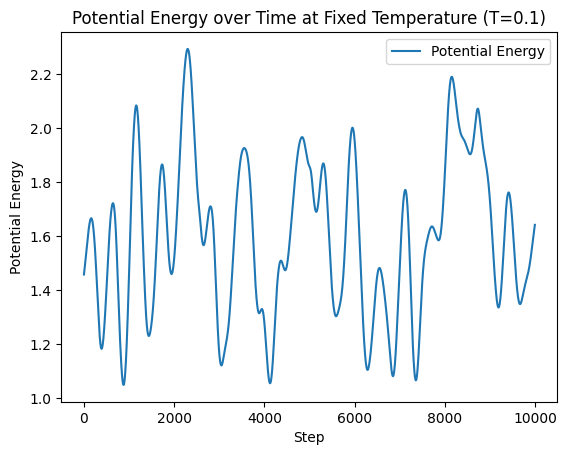

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view
import os

# Directory to store trajectories
output_dir = r"C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 150000  # Number of steps
box_size = 100.0  # Size of the cubic box
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
k = 0.2  # Spring constant
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.2  # Depth of repulsive LJ potential (fixed)
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant
target_temperature = 0.1  # Fixed temperature

# Directory to store trajectories
output_dir = r"C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, k):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Initialize positions and velocities
positions = initialize_chain(n_particles, box_size, r0)
velocities = initialize_velocities(n_particles, target_temperature, mass)
forces = compute_harmonic_forces(positions, k, r0, box_size) + \
         compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
         compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

# Arrays to store properties during sampling
Rg_values = []
Ree_values = []
potential_energies = []

# Initialize an empty list to store trajectories after equilibration
trajectories = []

# Run simulation loop
for step in range(total_steps):
    positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, k)
    if step % rescale_interval == 0:
        velocities = rescale_velocities(velocities, target_temperature, mass)

    # Store trajectories only after equilibration (step >= 140,000)
    if step >= 140000:
        trajectories.append(positions.copy())  # Store a copy of the positions at each step

        # Compute properties for this step
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        # Lennard-Jones Potentials
        def lj_repulsive_potential(r, epsilon, sigma):
            if r < 2**(1/6) * sigma:
                return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6 + 0.25)
            return 0.0

        def lj_attractive_potential(r, epsilon, sigma):
            return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

        E_LJ = 0.0
        for i in range(n_particles - 1):
            for j in range(i + 1, n_particles):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff:
                    if abs(i - j) == 2:
                        # Repulsive Lennard-Jones Potential
                        E_LJ += lj_repulsive_potential(distance, epsilon_repulsive, sigma)
                    elif abs(i - j) > 2:
                        # Attractive Lennard-Jones Potential
                        E_LJ += lj_attractive_potential(distance, epsilon_attractive, sigma)

        potential_energy = E_harmonic + E_LJ

        # Store values
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)

# Convert lists to NumPy arrays for easier calculations
Rg_values = np.array(Rg_values)
Ree_values = np.array(Ree_values)
potential_energies = np.array(potential_energies)
trajectories = np.array(trajectories)  # Convert the trajectory list to a NumPy array

# Save the trajectory data
trajectory_file_path = os.path.join(output_dir, f"trajectories_T_0.1_opt_high_step_{target_temperature:.2f}.npy")
np.save(trajectory_file_path, trajectories)
print(f"Trajectories saved to: {trajectory_file_path}")

# Plotting the results
plt.figure()
plt.plot(Rg_values, label='Radius of Gyration')
plt.xlabel('Step')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration over Time at Fixed Temperature (T=0.1)')
plt.legend()
plt.show()

plt.figure()
plt.plot(Ree_values, label='End-to-End Distance')
plt.xlabel('Step')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance over Time at Fixed Temperature (T=0.1)')
plt.legend()
plt.show()

plt.figure()
plt.plot(potential_energies, label='Potential Energy')
plt.xlabel('Step')
plt.ylabel('Potential Energy')
plt.title('Potential Energy over Time at Fixed Temperature (T=0.1)')
plt.legend()
plt.show()




Trajectories saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.1_base_low_step_0.10.npy


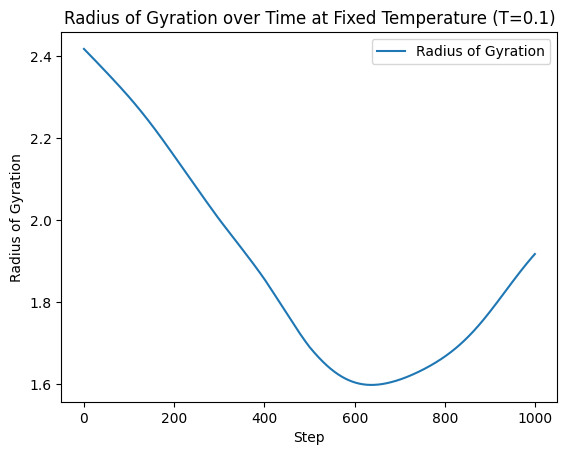

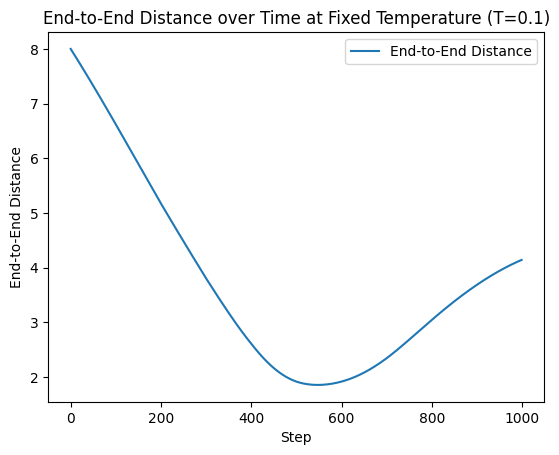

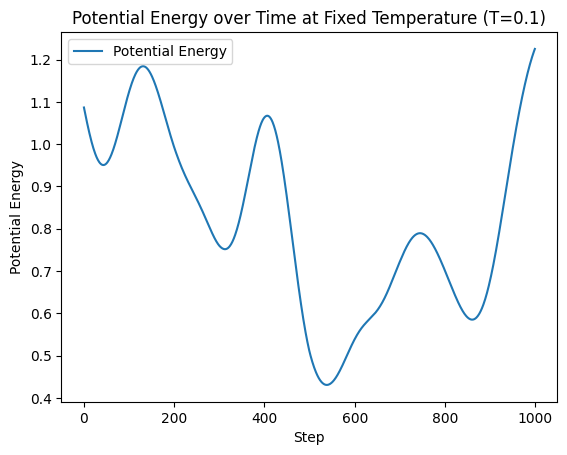

In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view
import os

# Directory to store trajectories
output_dir = r"C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 21000  # Number of steps
box_size = 100.0  # Size of the cubic box
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
k = 1.0  # Spring constant
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential (fixed)
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant
target_temperature = 0.1  # Fixed temperature

# Directory to store trajectories
output_dir = r"C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, k):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Initialize positions and velocities
positions = initialize_chain(n_particles, box_size, r0)
velocities = initialize_velocities(n_particles, target_temperature, mass)
forces = compute_harmonic_forces(positions, k, r0, box_size) + \
         compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
         compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

# Arrays to store properties during sampling
Rg_values = []
Ree_values = []
potential_energies = []

# Initialize an empty list to store trajectories after equilibration
trajectories = []

# Run simulation loop
for step in range(total_steps):
    positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, k)
    if step % rescale_interval == 0:
        velocities = rescale_velocities(velocities, target_temperature, mass)

    # Store trajectories only after equilibration (step >= 140,000)
    if step >= 20000:
        trajectories.append(positions.copy())  # Store a copy of the positions at each step

        # Compute properties for this step
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        # Lennard-Jones Potentials
        def lj_repulsive_potential(r, epsilon, sigma):
            if r < 2**(1/6) * sigma:
                return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6 + 0.25)
            return 0.0

        def lj_attractive_potential(r, epsilon, sigma):
            return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

        E_LJ = 0.0
        for i in range(n_particles - 1):
            for j in range(i + 1, n_particles):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff:
                    if abs(i - j) == 2:
                        # Repulsive Lennard-Jones Potential
                        E_LJ += lj_repulsive_potential(distance, epsilon_repulsive, sigma)
                    elif abs(i - j) > 2:
                        # Attractive Lennard-Jones Potential
                        E_LJ += lj_attractive_potential(distance, epsilon_attractive, sigma)

        potential_energy = E_harmonic + E_LJ

        # Store values
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)

# Convert lists to NumPy arrays for easier calculations
Rg_values = np.array(Rg_values)
Ree_values = np.array(Ree_values)
potential_energies = np.array(potential_energies)
trajectories = np.array(trajectories)  # Convert the trajectory list to a NumPy array

# Save the trajectory data
trajectory_file_path = os.path.join(output_dir, f"trajectories_T_0.1_base_low_step_{target_temperature:.2f}.npy")
np.save(trajectory_file_path, trajectories)
print(f"Trajectories saved to: {trajectory_file_path}")

# Plotting the results
plt.figure()
plt.plot(Rg_values, label='Radius of Gyration')
plt.xlabel('Step')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration over Time at Fixed Temperature (T=0.1)')
plt.legend()
plt.show()

plt.figure()
plt.plot(Ree_values, label='End-to-End Distance')
plt.xlabel('Step')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance over Time at Fixed Temperature (T=0.1)')
plt.legend()
plt.show()

plt.figure()
plt.plot(potential_energies, label='Potential Energy')
plt.xlabel('Step')
plt.ylabel('Potential Energy')
plt.title('Potential Energy over Time at Fixed Temperature (T=0.1)')
plt.legend()
plt.show()




Trajectories saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.1_base_low_step_0.10.npy


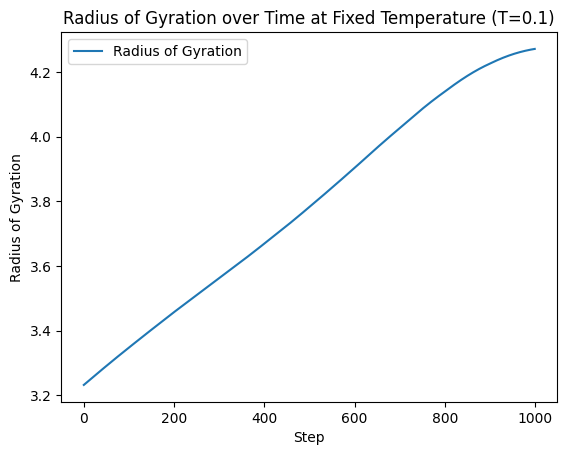

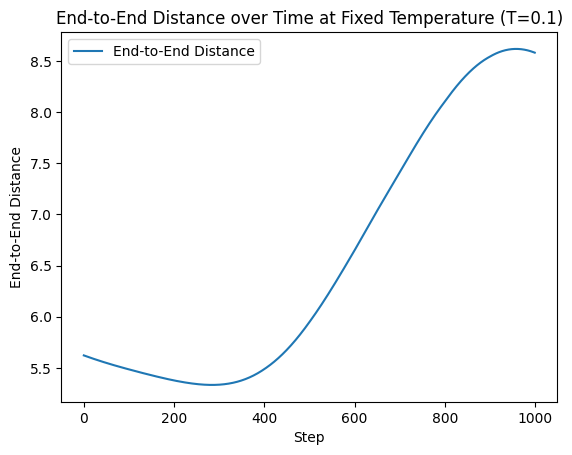

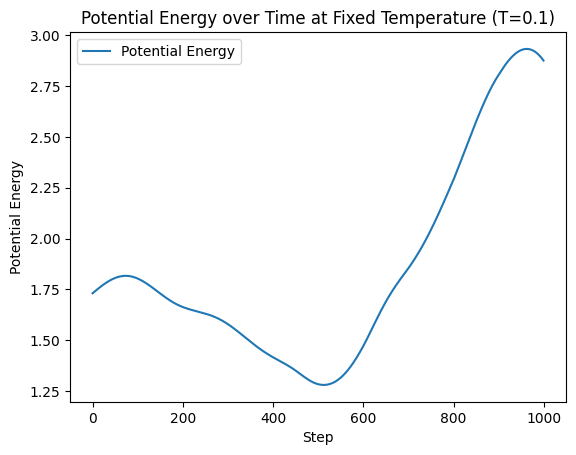

In [4]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view
import os

# Directory to store trajectories
output_dir = r"C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 21000  # Number of steps
box_size = 100.0  # Size of the cubic box
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
k = 0.2  # Spring constant
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.2  # Depth of repulsive LJ potential (fixed)
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant
target_temperature = 0.1  # Fixed temperature

# Directory to store trajectories
output_dir = r"C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, k):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Initialize positions and velocities
positions = initialize_chain(n_particles, box_size, r0)
velocities = initialize_velocities(n_particles, target_temperature, mass)
forces = compute_harmonic_forces(positions, k, r0, box_size) + \
         compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
         compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

# Arrays to store properties during sampling
Rg_values = []
Ree_values = []
potential_energies = []

# Initialize an empty list to store trajectories after equilibration
trajectories = []

# Run simulation loop
for step in range(total_steps):
    positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, k)
    if step % rescale_interval == 0:
        velocities = rescale_velocities(velocities, target_temperature, mass)

    # Store trajectories only after equilibration (step >= 140,000)
    if step >= 20000:
        trajectories.append(positions.copy())  # Store a copy of the positions at each step

        # Compute properties for this step
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        # Lennard-Jones Potentials
        def lj_repulsive_potential(r, epsilon, sigma):
            if r < 2**(1/6) * sigma:
                return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6 + 0.25)
            return 0.0

        def lj_attractive_potential(r, epsilon, sigma):
            return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

        E_LJ = 0.0
        for i in range(n_particles - 1):
            for j in range(i + 1, n_particles):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff:
                    if abs(i - j) == 2:
                        # Repulsive Lennard-Jones Potential
                        E_LJ += lj_repulsive_potential(distance, epsilon_repulsive, sigma)
                    elif abs(i - j) > 2:
                        # Attractive Lennard-Jones Potential
                        E_LJ += lj_attractive_potential(distance, epsilon_attractive, sigma)

        potential_energy = E_harmonic + E_LJ

        # Store values
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)

# Convert lists to NumPy arrays for easier calculations
Rg_values = np.array(Rg_values)
Ree_values = np.array(Ree_values)
potential_energies = np.array(potential_energies)
trajectories = np.array(trajectories)  # Convert the trajectory list to a NumPy array

# Save the trajectory data
trajectory_file_path = os.path.join(output_dir, f"trajectories_T_0.1_base_low_step_{target_temperature:.2f}.npy")
np.save(trajectory_file_path, trajectories)
print(f"Trajectories saved to: {trajectory_file_path}")

# Plotting the results
plt.figure()
plt.plot(Rg_values, label='Radius of Gyration')
plt.xlabel('Step')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration over Time at Fixed Temperature (T=0.1)')
plt.legend()
plt.show()

plt.figure()
plt.plot(Ree_values, label='End-to-End Distance')
plt.xlabel('Step')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance over Time at Fixed Temperature (T=0.1)')
plt.legend()
plt.show()

plt.figure()
plt.plot(potential_energies, label='Potential Energy')
plt.xlabel('Step')
plt.ylabel('Potential Energy')
plt.title('Potential Energy over Time at Fixed Temperature (T=0.1)')
plt.legend()
plt.show()


